# Galaxy Simulation

## Kreisbahn der Erde um die Sonne 2D

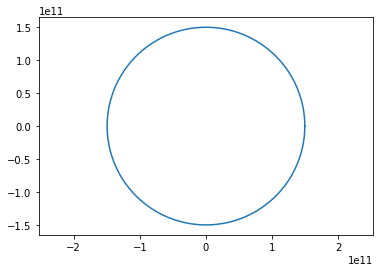

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def calc_acceleration(force, mass):
    if mass <= 0:
        raise TypeError('Mass has to be greater than 0')
    return (1/mass)*force

def next_location(mass, position, speed, acceleration, delta_t):
    return (position + delta_t * speed + (delta_t**2/2)*acceleration)

def calc_gravitational_force(mass1, mass2, pos1, pos2):
    delta_pos = np.linalg.norm(pos2-pos1)
    return (6.673*10**-11)*(((mass1*mass2)/delta_pos**3)*(pos2-pos1))

def calc_mass_focus(ignore, masses, positions):
    total_mass = np.sum(masses)
    
    tmp_loc = np.zeros(3, dtype=np.float64)
    
    for i in range(masses.size):
        if i == ignore:
            continue
        tmp_loc = tmp_loc + (masses[i] * positions[i])    
    return (1/(total_mass - masses[i]))*tmp_loc



body_amount = 2
positions = np.zeros((body_amount, 3), dtype=np.float64)
speed = np.zeros((body_amount, 3), dtype=np.float64)
radius = np.zeros((body_amount), dtype=np.float64)
mass = np.zeros((body_amount), dtype=np.float64)

positions[0] = np.array([0,0,0])
speed[0] = [0,0,0]
mass[0] = 1.989*10**30

positions[1] = np.array([1.496*10**11, 0, 0])
speed[1] = np.array([0, 29780, 0])
mass[1] = 5.972*10**24

x_vals = []
y_vals = []

timestep = 100
step_amount = 315400

for i in range(step_amount):
    body = 1
    mass_foc_pos = positions[0]
    mass_foc_weight = mass[0]
    grav_force = calc_gravitational_force(mass[body], mass_foc_weight, positions[body], mass_foc_pos)
    accel = calc_acceleration(grav_force, mass[body])
    speed[body] = speed[body] + accel*timestep
    positions[body] = next_location(mass[body], positions[body], speed[body], accel, timestep)
    x_vals.append(positions[body][0])
    y_vals.append(positions[body][1])

plt.axis('equal')
plt.plot(x_vals, y_vals)

## Testing Cython

### Cython optimised Version

In [1]:
%load_ext cython

In [5]:
%%cython -a

cimport cython

import numpy as np
cimport numpy as np
from numpy cimport ndarray
from scipy.linalg import norm

ctypedef np.float64_t DTYPE_t

# Maybe add some excepts for exceptions?
# cdef np.ndarray[DTYPE_t, ndim=1] g_force_cython(long mass1, long mass2, np.ndarray[DTYPE_t, ndim=1] pos1, np.ndarray[np.float64_t, ndim=1] pos2):
@cython.cdivision(True)
cdef np.ndarray[DTYPE_t, ndim=1] g_force_cython():
    """
    Brechnet Gravitionskraft, mit der eine Punktmasse mass1, die sich an pos1
    befindet, von einer Punktmasse mass2, die sich an pos2
    befindet, angezogen wird

    params:
        mass1: Punktmasse eines Koerpers 1
        mass2: Punktmasse eines zweiten Koerpers 2
        pos1: Position von Koerper 1 als numpy Array
        pos2: Position von Koerper 2 als numpy Array
    return:
        Gravitationskraft als Vektor
    """
    cdef double G_CONSTANT = 6.673 * 10**-11
    cdef long mass1 = 5000000000
    cdef long mass2 = 7000000000
    cdef np.ndarray[DTYPE_t, ndim=1] pos1 = np.array([1.0, 2.0, 3.0])
    cdef np.ndarray[DTYPE_t, ndim=1] pos2 = np.array([2.0, 3.0, 4.0])
    
    cdef np.ndarray[DTYPE_t, ndim=1] delta_pos = pos2 - pos1
    cdef float abs_dpos = norm(pos2 - pos1)  # how to optimise this?
    cdef np.ndarray[DTYPE_t, ndim=1] gforce = G_CONSTANT * (((mass1)/abs_dpos**3)*mass2) * delta_pos
    return gforce

<cyfunction __Pyx_CFunc_ndarray_______to_py.<locals>.wrap at 0x7fa8ea9b6608>


In [4]:
%%cython

import timeit

timeit.repeat(stmt='g_force_cython()', repeat=10000, number=10, globals=globals())

NameError: name 'g_force_cython' is not defined

### Slow Version using NumPy Arrays only

In [65]:
%%cython -a

from numpy.linalg import norm
from numpy import array

def g_force():
    """
    Brechnet Gravitionskraft, mit der eine Punktmasse mass1, die sich an pos1
    befindet, von einer Punktmasse mass2, die sich an pos2
    befindet, angezogen wird

    params:
        mass1: Punktmasse eines Koerpers 1
        mass2: Punktmasse eines zweiten Koerpers 2
        pos1: Position von Koerper 1 als numpy Array
        pos2: Position von Koerper 2 als numpy Array
    return:
        Gravitationskraft als Vektor
    """
    G_CONSTANT = 6.673 * 10**-11
    mass1 = 5000000000
    mass2 = 7000000000
    pos1 = array([1, 2, 3])
    pos2 = array([2, 3, 4])

    delta_pos = pos2 - pos1
    abs_dpos = norm(delta_pos)
    return G_CONSTANT * (((mass1)/abs_dpos**3)*mass2) * delta_pos

In [66]:
import timeit

timeit.repeat(stmt='g_force()', repeat=10000, number=10, globals=globals())

[0.0003804949992627371,
 0.00024109199875965714,
 0.0008693849995324854,
 0.00011230500058445614,
 0.00011090799853263889,
 0.00011090799853263889,
 0.00016398799925809726,
 0.00011146700126118958,
 0.00020784799926332198,
 0.00010979100079566706,
 0.00010839400056283921,
 0.00011035000170522835,
 0.00010867300079553388,
 0.00012850799976149574,
 0.00010979100079566706,
 0.00010839400056283921,
 0.0001737649999995483,
 0.00010951100011880044,
 0.00010867300079553388,
 0.00010867300079553388,
 0.0007143359998735832,
 0.00012040599904139526,
 0.00010699700033001136,
 0.00010671800009731669,
 0.0001273910002055345,
 0.0003514420004648855,
 0.00024360600036743563,
 0.0002458419985487126,
 0.00039502300023741554,
 0.00026176500068686437,
 0.00047128900041570887,
 0.00010783499965327792,
 0.00010643799942045007,
 0.0001882920005300548,
 7.598699994559865e-05,
 0.0008640759988338687,
 0.00025478099996689707,
 0.0002558979995228583,
 0.0002634410011523869,
 0.0005369400005292846,
 0.0001829839